Marysa M. Laguë

2019.09.19

# ACDC "Weird World"

### Analysis of ISCA runs by Marianne Pietschnig 

#### Run descriptions:
<update this>

In [ ]:
%matplotlib inline
import sys
sys.path.append('./scripts')

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing

import time

from copy import copy 

#from joblib import Parallel, delayed
import multiprocessing

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
#import brewer2mpl as cbrew
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter

from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

from mpl_toolkits.axes_grid1 import make_axes_locatable

# from matplotlib.gridspec import GridSpec
#import matplotlib.gridspec as gridspec
from matplotlib import gridspec

# OS interaction
import os
import sys

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

#from season_mean import season_mean

import matplotlib.colors as mcolors

import glob

In [156]:
#xr.set_options(enable_cftimeindex=True)


In [157]:
isca_outpath = '/Users/mlague/GoogleDrive/School/Research/ACDC/ISCA/'
case = 'ctrl'

filelist = glob.glob(isca_outpath + case + '/*/*.nc')
filelist.sort()

In [158]:
with xr.set_options(enable_cftimeindex=True):
    ds_ctrl = xr.open_mfdataset(filelist,autoclose='true',decode_times=False)

In [159]:
#ds_ctrl = xr.open_mfdataset(filelist,autoclose='true')

lat = ds_ctrl['lat'].values[:]
lon = ds_ctrl['lon'].values[:]
lev = ds_ctrl['pfull'].values[:]
time = ds_ctrl['time']

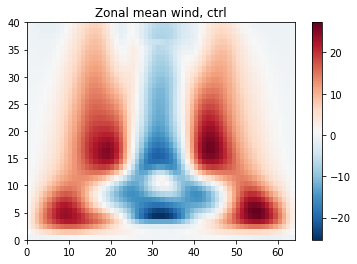

In [136]:
u_zonal = ds_ctrl['ucomp'].mean('lon').mean('time').values[:]
plt.pcolormesh(u_zonal,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.title('Zonal mean wind, ctrl')

Difference between northerna and southern hemisphere zonal winds:

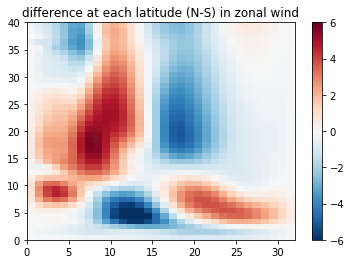

In [134]:
du = u_zonal[:,32:65] - np.fliplr(u_zonal[:,0:32])
plt.pcolormesh(du,cmap=plt.cm.RdBu_r)
plt.colorbar()
plt.clim([-6,6])
plt.title('difference at each latitude (N-S) in zonal wind')

# add countours of zonal mean wind for NH ... or for SH

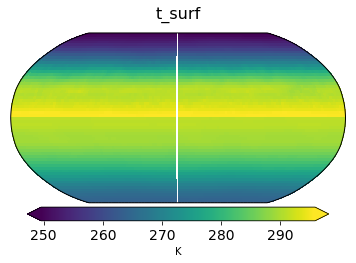

In [151]:
var = 't_surf'

mapdata = ds_ctrl[var].mean('time').values[:]


ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

LN,LT = np.meshgrid(lon,lat)

# cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
cs = plt.pcolormesh(LN,LT,mapdata,transform=ccrs.PlateCarree())

plt.set_cmap(copy(plt.cm.viridis))

plt.title(var,fontsize=16,y=1.05)
#plt.clim([240,300])

#     if clim:
#         plt.clim(clim)  
#         cs.set_clim(clim[0],clim[1])
#         cs.set_clim(clim)

cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(ds_ctrl[var].units)

#cbar.set_clim(clim)

cm = plt.get_cmap()




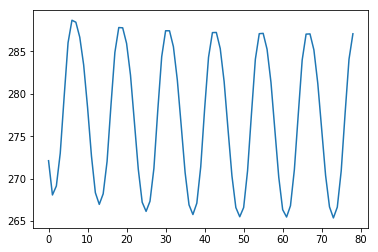

In [152]:
var = 't_surf'
t_ts = ds_ctrl[var].mean('lat').mean('lon')

plt.plot(t_ts)



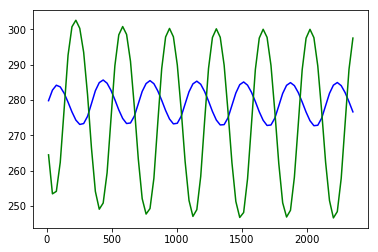

In [153]:
data = ds_ctrl[var].values[:]
NH_ts = np.mean(np.mean(data[:,32:65,:],2),1)
SH_ts = np.mean(np.mean(data[:,0:32,:],2),1)

plt.plot(time,SH_ts,'b',label='south')
plt.plot(time,NH_ts,'g',label='north')



In [154]:
data = ds_ctrl[var].mean('lon').
values[:]
NH_ts = np.mean(data[:,55,:],1)
SH_ts = np.mean(data[:,10,:],1)

plt.plot(time,SH_ts,'b',label='south')
plt.plot(time,NH_ts,'g',label='north')


SyntaxError: invalid syntax (<ipython-input-154-380fc9348aa2>, line 1)

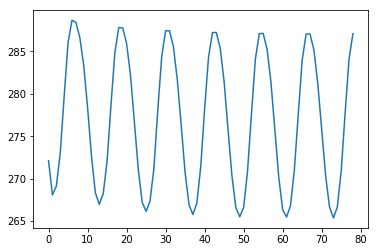

In [155]:
data = ds_ctrl['t_surf'].values[:]
data_ts = np.mean(np.mean(data,2),1)
plt.plot(data_ts)